# SIRD Model Implementation

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter

### Data Processing

In [35]:
# Handle data
# We are given the initial number of dead people, 22
# Assuming that 1% of cases result in death, this gives us an initial removed number of 22*100

who_data = pd.read_csv('cholera_data.csv')

N = 9426017
r_scale = 200.0

I_data = np.array( ( who_data.iloc[:,0]) / N )
R_data = np.array( ( who_data.iloc[:,1]*r_scale ) / N )
D_data = np.array( ( who_data.iloc[:,1]) / N )
S_data = np.array( 1 - I_data - R_data - D_data )

times = who_data.iloc[:,2]

I0 = I_data[0]
R0 = R_data[0]
S0 = S_data[0]
D0 = D_data[0]
W0 = 0.0

### Basic SIRD Model

In [138]:
def SIRD_model(y,t,alpha,beta, mu, h):
    S, I, R, D = y
    dSdt = -(beta)*S*I - h*D
    dIdt = (beta)*S*I- alpha*I - mu*I + h*D
    dRdt = alpha*I 
    dDdt = mu*I 
    
    return dSdt, dIdt, dRdt, dDdt

In [139]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
mu = 0.1
h = 0.1
c = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 17
tspan = times[0:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[0:num_days], I_data[0:num_days], R_data[0:num_days], D_data[0:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, mu,h = params['alpha'].value, params['beta'].value, params['mu'].value,  params['h'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, mu, h)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('mu', value=mu, min=0, max=10)
params.add('h', value=h, min=0, max=10)

result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')



In [140]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
mu = result.params['mu'].value
h = result.params['h'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta,"\nc =", c, "\nh =", h, "\nmu =", mu )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta,  mu,h)))
S_modelb = sol[:,0]
I_modelb = sol[:,1]
R_modelb = sol[:,2]
D_modelb = sol[:,3]

Optimal Parameters: 
alpha = 0.009876705855023649 
beta = 0.014835715501257951 
c = 0.1 
h = 1.3311694021792548 
mu = 0.00042444757881232587


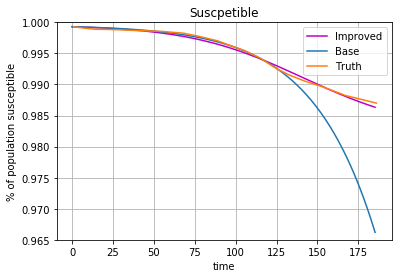

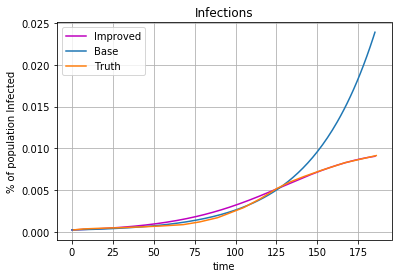

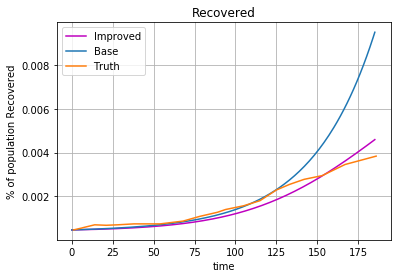

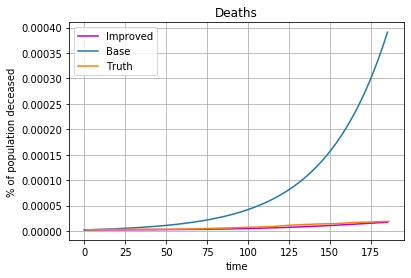

In [143]:


# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model[0:186], label = "Improved", color='m')
plt.plot(t[0:186], S_modelb[0:186], label = "Base")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.965,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model[0:186], label = "Improved", color='m')
plt.plot(t[0:186], I_modelb[0:186], label = "Base")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model[0:186], label = "Improved", color='m')
plt.plot(t[0:186], R_modelb[0:186], label = "Base")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model[0:186], label = "Improved", color='m')
plt.plot(t[0:186], D_modelb[0:186], label = "Base")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()



## Improved Model

In [173]:
def SIRD_model(y,t,alpha,beta, beta2, mu, c, h, w_1, w_2, phi, theta):
    S, I, R, D = y
    dSdt = (-beta*S*I) + (theta*S*I) - (c*S*R) - (h*D) + (beta2*I) - phi*(S*I+I*R)
    dIdt = (beta*S*I) - (theta*S*I) - (w_1*alpha*I + w_2*I) - (mu*I) + (c*S*R) + (h*D) - (beta2*I) + phi*(S*I+I*R)
    dRdt = (w_1*alpha*I + w_2*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt

In [174]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
beta2 = 0.1
mu = 0.1
h = 0.1
c = 0.1
phi = 0.1
w_1 = 0.1
w_2 = 0.1
theta = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tmin=0
tspan = times[tmin:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[tmin:num_days], I_data[tmin:num_days], R_data[tmin:num_days], D_data[tmin:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, beta2, mu, c, h, w_1, w_2, phi, theta = params['alpha'].value, params['beta'].value, params['beta2'].value, params['mu'].value, params['c'].value, params['h'].value, params['w_1'].value, params['w_2'].value, params['phi'].value, params['theta'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, beta2, mu, c, h, w_1, w_2, phi, theta)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('beta2', value=beta2, min=0, max=10)
params.add('mu', value=mu, min=0, max=1)
params.add('c', value=c, min=0, max=10)
params.add('h', value=h, min=0, max=10)
params.add('w_1', value=w_1, min=1, max=10)
params.add('w_2', value=w_2, min=0, max=10)
params.add('phi', value=phi, min=0, max=10)
params.add('theta', value=theta, min=0, max=10)


result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

C:\Users\dusan\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [175]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
beta2 = result.params['beta2'].value
c = result.params['c'].value
mu = result.params['mu'].value
h = result.params['h'].value
w_1 = result.params['w_1'].value
w_2 = result.params['w_2'].value
phi = result.params['phi'].value
theta = result.params['theta'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nbeta2 =", beta2,"\nc =", c, "\nh =", h, "\nmu =", mu , "\nw_1 =", w_1, "\nw_2 =", w_2 , "\nphi =", phi , "\ntheta =", theta )

t = np.linspace(0, 3000, 3000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, beta2, mu, c, h, w_1, w_2, phi, theta  )))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
D_model = sol[:,3]

Optimal Parameters: 
alpha = 0.005497199841737466 
beta = 1.9040040720934854 
beta2 = 1.9400877547771893 
c = 2.912946434063812e-07 
h = 0.020194941172014258 
mu = 2.282158088207087e-05 
w_1 = 1.0391330230570053 
w_2 = 0.0004838884307567515 
phi = 0.07237374635788274 
theta = 0.00015862344484807167


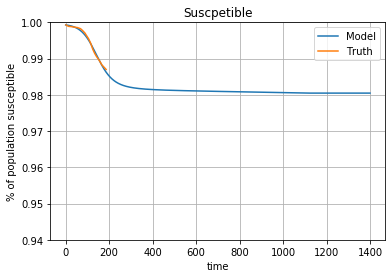

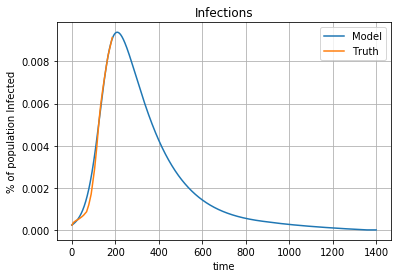

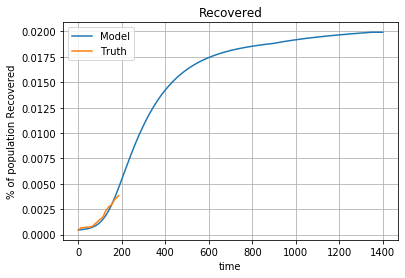

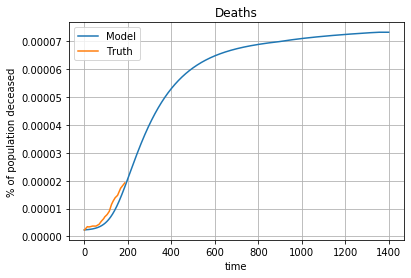

In [13]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.940,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


### SIRD Model with Control Mechanism 1

In [151]:
def SIRD_model(y,t,alpha,beta, beta2, c, h, mu):
    S, I, R, D = y
    dSdt = (-beta*S*I) - (c*S*R) - (h*D) + (beta2*I) 
    dIdt = (beta*S*I)  - (alpha*I) - (mu*I) + (c*S*R) + (h*D) - (beta2*I)
    dRdt = (alpha*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt

In [152]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
beta2 = 0.1
mu = 0.1
c = 0.1
h = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tmin=0
tspan = times[tmin:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[tmin:num_days], I_data[tmin:num_days], R_data[tmin:num_days], D_data[tmin:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, beta2, mu, c, h = params['alpha'].value, params['beta'].value, params['beta2'].value, params['mu'].value, params['c'].value, params['h'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, beta2, mu, c, h)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('beta2', value=beta2, min=0, max=10)
params.add('mu', value=mu, min=0, max=10)
params.add('c', value=mu, min=0, max=10)
params.add('h', value=mu, min=0, max=10)


result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

In [155]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
beta2 = result.params['beta2'].value
mu = result.params['mu'].value
h = result.params['h'].value
c = result.params['c'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nbeta2 =", beta2, "\nmu =", mu )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, beta2, mu,c , h)))
S_model_1 = sol[:,0]
I_model_1 = sol[:,1]
R_model_1 = sol[:,2]
D_model_1 = sol[:,3]

Optimal Parameters: 
alpha = 0.01885222102658346 
beta = 0.480045007785197 
beta2 = 7.750310244560215 
mu = 4.013282181569931


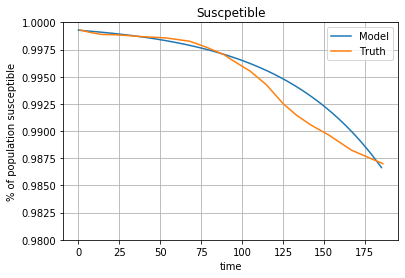

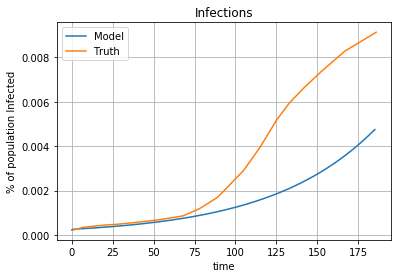

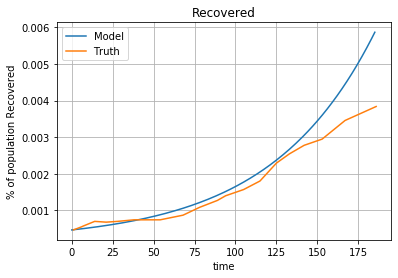

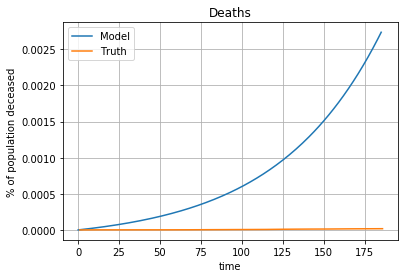

In [156]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model_1[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.980,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model_1[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model_1[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model_1[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


### SIRD Model with Control Mechanism #2

In [176]:
def SIRD_model(y,t,alpha,beta, mu, w_1, w_2):
    S, I, R, D = y
    dSdt = (-beta*S*I) - (c*S*R) - (h*D)
    dIdt = (beta*S*I)  - (w_1*alpha*I + w_2*I) - (mu*I) + (c*S*R) + (h*D) 
    dRdt = (w_1*alpha*I + w_2*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt

In [177]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
mu = 0.1
w_1 = 0.1
w_2 = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tmin=0
tspan = times[tmin:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[tmin:num_days], I_data[tmin:num_days], R_data[tmin:num_days], D_data[tmin:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, mu, w_1, w_2 = params['alpha'].value, params['beta'].value, params['mu'].value, params['w_1'].value, params['w_2'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, mu, w_1, w_2)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('mu', value=mu, min=0, max=1)
params.add('w_1', value=w_1, min=1, max=10)
params.add('w_2', value=w_2, min=0, max=10)


result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

In [178]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
mu = result.params['mu'].value
w_1 = result.params['w_1'].value
w_2 = result.params['w_2'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nmu =", mu , "\nw_1 =", w_1, "\nw_2 =", w_2  )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, mu, w_1, w_2)))
S_model_2 = sol[:,0]
I_model_2 = sol[:,1]
R_model_2 = sol[:,2]
D_model_2 = sol[:,3]

Optimal Parameters: 
alpha = 4.719619361427194 
beta = 4.202183727380665 
mu = 0.9988499784510734 
w_1 = 1.0000000228464536 
w_2 = 1.626747581084942e-07


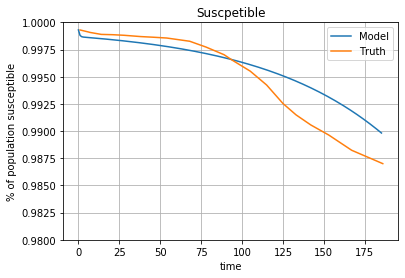

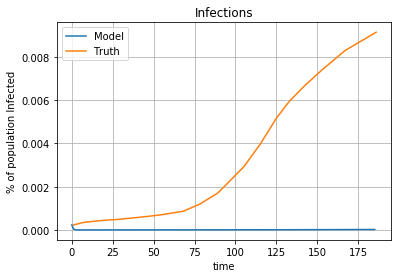

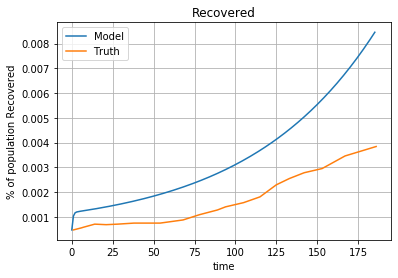

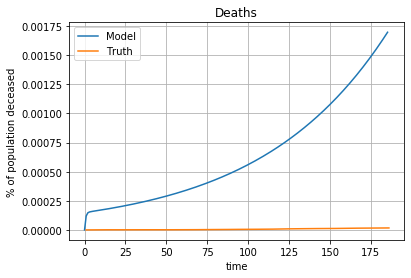

In [179]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model_2[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.98,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model_2[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model_2[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model_2[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


### SIRD Model with Control Mechanism #3

In [53]:
def SIRD_model(y,t,alpha,beta, mu, c, h, theta):
    S, I, R, D = y
    dSdt = ((-beta)*S*I) + (theta*S*I) - (c*S*R) - (h*D) 
    dIdt = ((beta)*S*I)  - (theta*S*I) - (alpha*I) - (mu*I) + (c*S*R) + (h*D) 
    dRdt = (alpha*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt

In [54]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
mu = 0.1
theta = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tmin=0
tspan = times[tmin:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[tmin:num_days], I_data[tmin:num_days], R_data[tmin:num_days], D_data[tmin:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta ,mu, theta = params['alpha'].value, params['beta'].value, params['mu'].value, params['theta'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, mu, theta)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('mu', value=mu, min=0, max=1)
params.add('theta', value=theta, min=0, max=10)


result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

In [24]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
mu = result.params['mu'].value
theta = result.params['theta'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nmu =", mu , "\ntheta =", theta )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, mu, theta  )))
S_model_3 = sol[:,0]
I_model_3 = sol[:,1]
R_model_3 = sol[:,2]
D_model_3 = sol[:,3]

Optimal Parameters: 
alpha = 0.009180176516717653 
beta = 0.12897255489219717 
mu = 2.105617258330028e-08 
theta = 0.09867196515689125


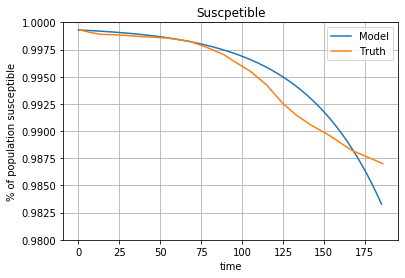

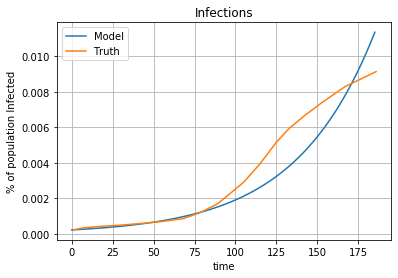

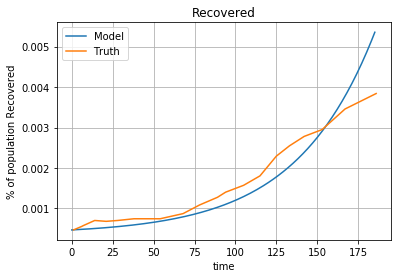

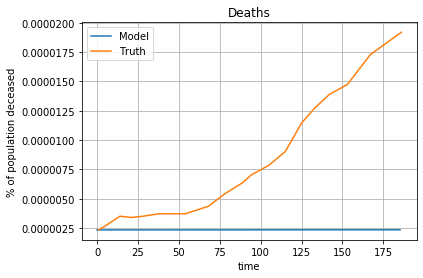

In [25]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model_3[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.980,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model_3[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model_3[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model_3[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


### SIRD Model with Control Mechanism #4

In [56]:
def SIRD_model(y,t,alpha,beta, mu, phi):
    S, I, R, D = y
    dSdt = ((-beta)*S*I) - (c*S*R) - (h*D) - phi*(S*I+S*R)
    dIdt = ((beta)*S*I)  - (alpha*I) - (mu*I) + (c*S*R) + (h*D)+ phi*(S*I+S*R)
    dRdt = (alpha*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt

In [57]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
mu = 0.1
phi = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tmin=0
tspan = times[tmin:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[tmin:num_days], I_data[tmin:num_days], R_data[tmin:num_days], D_data[tmin:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, mu, phi = params['alpha'].value, params['beta'].value, params['mu'].value, params['phi'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, mu, phi)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('mu', value=mu, min=0, max=1)
params.add('phi', value=phi, min=0, max=10)


result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

In [28]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
mu = result.params['mu'].value
phi = result.params['phi'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nmu =", mu ,  "\nphi =", phi  )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, mu, phi  )))
S_model_4 = sol[:,0]
I_model_4 = sol[:,1]
R_model_4 = sol[:,2]
D_model_4 = sol[:,3]

Optimal Parameters: 
alpha = 0.006800717146659974 
beta = 1.4441231543926847e-09 
mu = 2.8113000816176736e-10 
phi = 0.01690021065448688


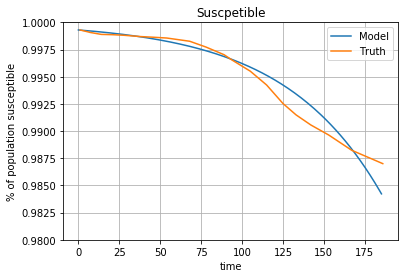

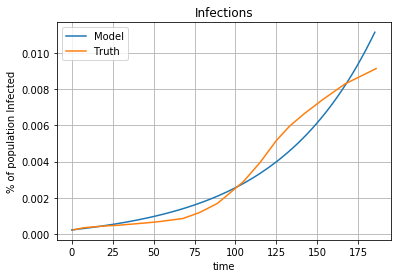

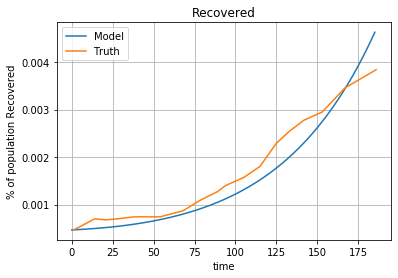

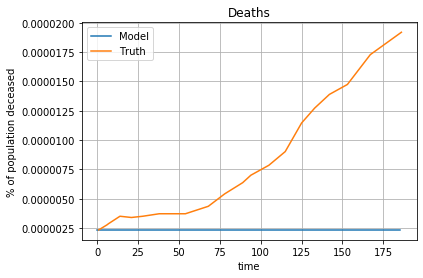

In [34]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model_4[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.980,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model_4[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model_4[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model_4[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


## Recoveries

In [129]:
round(max(R_model[:1500])*N)

163210.0

## Deaths 

In [134]:
round(max(D_model[:1500])*N)

630.0